# Importing Libraries

In [2]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage.measure import label as connected_components
import imageio.v3 as imageio

from torch_em.util.util import get_random_colors

from micro_sam import util
from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.instance_segmentation import(
    InstanceSegmentationWithDecoder,
    AutomaticMaskGenerator,
    get_predictor_and_decoder,
    mask_data_to_segmentation
)


from micro_sam.sam_annotator import annotator_3d

c:\Users\Adam\miniforge3\envs\GPU-micro-sam\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


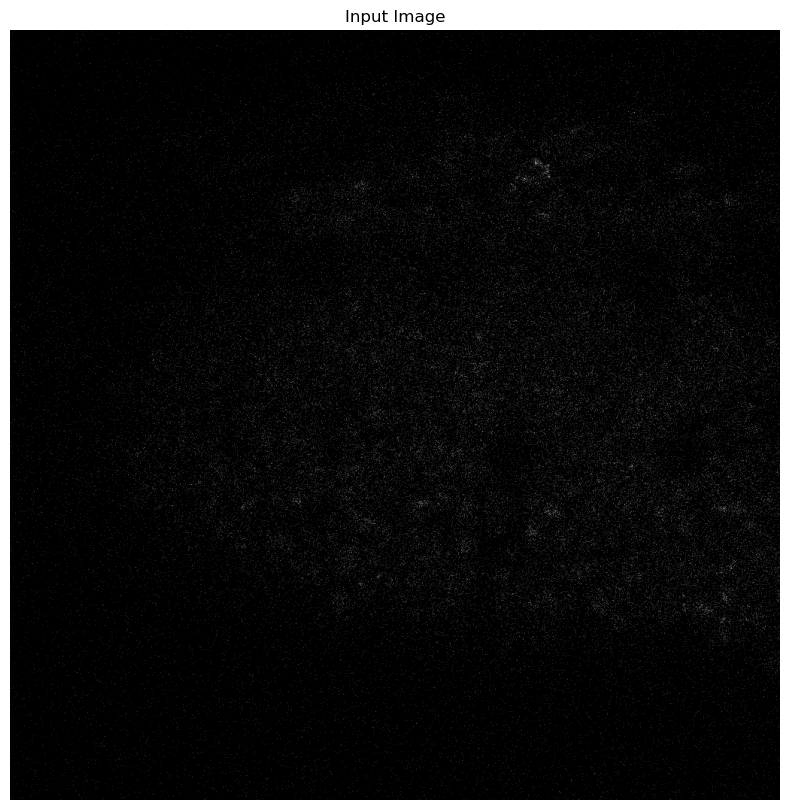

In [3]:
folderPath = os.path.abspath("Microscopy_Images")
data_paths = sorted(glob(os.path.join(folderPath,"*")))

for file in data_paths:
    image = imageio.imread(file)
    frame = image[0,0,:,:]
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.imshow(frame, cmap="gray")
    ax.set_title("Input Image")
    ax.axis("off")
    plt.show()
    plt.close()
    break

In [52]:
# Image Preprocessing
# Histogram equalization
# Denoising
#https://insights.oni.bio/blog/5-pre-processing-steps-to-improve-the-quality-of-your-fluorescence-microscopy-images
#https://medium.com/@kyawsawhtoon/a-tutorial-to-histogram-equalization-497600f270e2
#https://docs.opencv.org/3.4/d1/d79/group__photo__denoise.html#ga4c6b0031f56ea3f98f768881279ffe93

import cv2 as cv

def imagePreprocessing(frames, frameNum):
    processedFrames=[]
    clahe = cv.createCLAHE(clipLimit=5)
    for frame in frames:
        #pframe = clahe.apply(frame) +  30
        pFrame = cv.fastNlMeansDenoising(frame, h=10, templateWindowSize=7, searchWindowSize=21)
        processedFrames.append(pFrame)
    pframes = np.asarray(processedFrames)
    return pframes


In [4]:
def automatic_Segmentation(imageFrame, model):
    try:
        predictor, decoder = get_predictor_and_decoder(model_type=model, checkpoint_path=None)

        embeddings = util.precompute_image_embeddings(predictor=predictor, input_=imageFrame,ndim=2)

        ais = InstanceSegmentationWithDecoder(predictor, decoder)

        ais.initialize(image=imageFrame, image_embeddings=embeddings)

        prediction = ais.generate()
        prediction = mask_data_to_segmentation(prediction, with_background=True)
        return prediction
    
    except:
        print("Nothing Detected")

In [30]:
def automatic_mask_Generator(imageFrame, model):
    try:
        predictor=util.get_sam_model(
        model_type=model
        )

        embeddings = util.precompute_image_embeddings(
            predictor=predictor,
            input_=imageFrame,
            ndim=3
        )
        amg = AutomaticMaskGenerator(predictor)
        print(imageFrame.shape)
        amg.initialize(
            image=imageFrame,
            image_embeddings=embeddings
        )

        prediction = amg.generate(
            pred_iou_thresh=0.75,
            stability_score_thresh=0.75
        )
        prediction = mask_data_to_segmentation(prediction, with_background=True)
        return prediction
    
    except:
        print("Nothing detected here")
        return np.zeroes(1)
    
    

In [5]:
def extract_Channels(file):
    file = file.transpose(0,2,3,1)
    channel = file[:,:,0]
    channel1 = file[:,:,1]
    channel2 = file[:,:,2]
    channel3 = file[:,:,3]
    return channel, channel1, channel2,channel3

In [53]:
#https://pypi.org/project/tifffile/
#https://stackoverflow.com/questions/51520/how-to-get-an-absolute-file-path-in-python
#https://stackoverflow.com/questions/17429044/constructing-absolute-path-with-os-path-join
#https://docs.aspose.com/imaging/python-net/manipulating-tiff-images/
import tifffile as tiff
model = "vit_l_lm"
folderPath = os.path.abspath("Microscopy_Images")
data_paths = sorted(glob(os.path.join(folderPath,"*")))

channelResults = []
channel2Results = []
channel3Results = []
channel4Results = []

combined = []

for file in data_paths:
    tiffFile = tiff.imread(file)
    tiffFile = tiffFile.transpose(0,2,3,1)
    totalFrames = tiffFile.shape[0]
    ch, ch1, ch2, ch3 = extract_Channels(tiffFile)
    #Pass these arrays to the image preprocessing method (histogram equalization & denoiser)
    ch = imagePreprocessing(ch, totalFrames)
    ch1=imagePreprocessing(ch1, totalFrames)
    ch2 = imagePreprocessing(ch2, totalFrames)
    ch3 = imagePreprocessing(ch3, totalFrames)
    for frame in range(totalFrames):
        blue = automatic_Segmentation(ch[frame,:,:], model)
        yellow = automatic_Segmentation(ch1[frame,:,:], model)
        green = automatic_Segmentation(ch2[frame,:,:], model)
        red = automatic_Segmentation(ch3[frame,:,:], model)
        channelResults.append(blue)
        channel2Results.append(yellow)
        channel3Results.append(green)
        channel4Results.append(red)

Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


Nothing Detected


Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Nothing Detected


Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Nothing Detected


Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Nothing Detected


Compute Image Embeddings 2D.: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Text(0.5, 1.0, 'AIS Image')

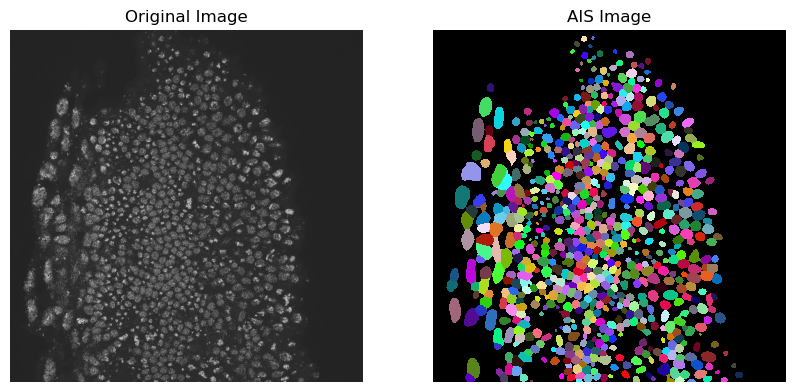

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch[23], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channelResults[23], cmap=get_random_colors(channelResults[23]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

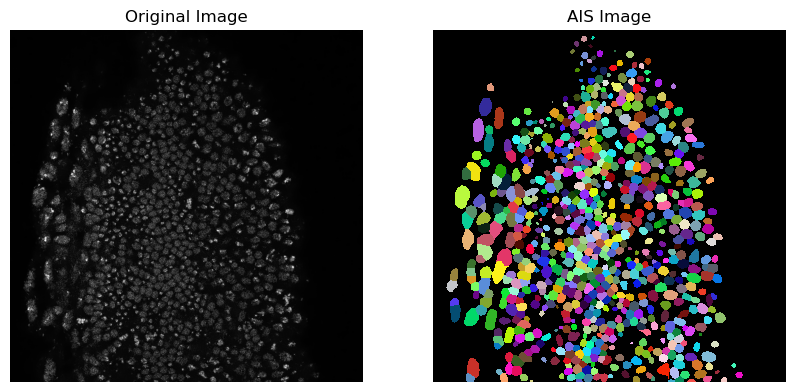

In [37]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch[23], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channelResults[23], cmap=get_random_colors(channelResults[23]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

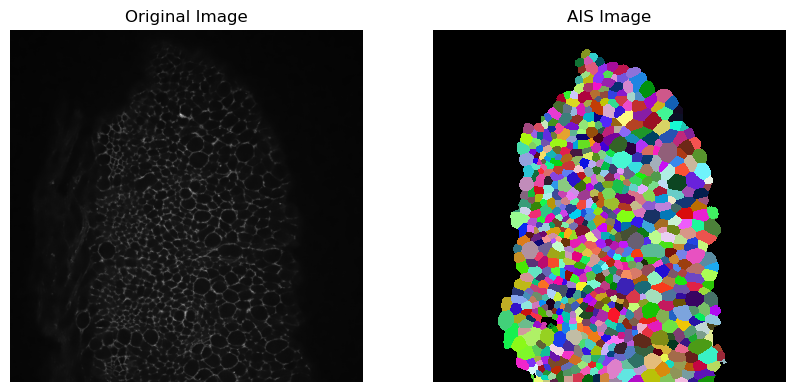

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch1[15], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel2Results[15], cmap=get_random_colors(channel2Results[15]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

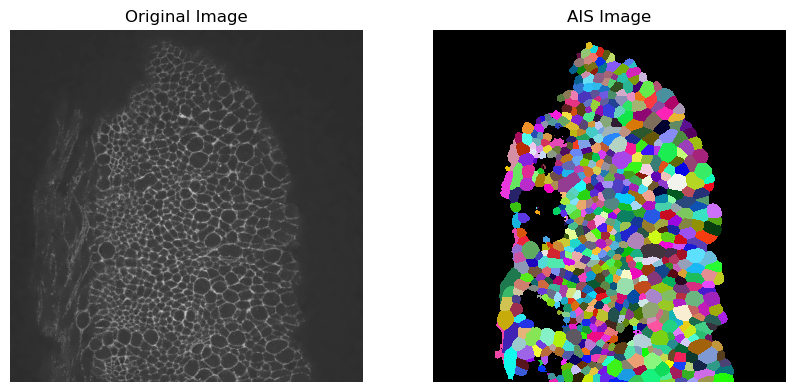

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch1[15], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel2Results[15], cmap=get_random_colors(channel2Results[15]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

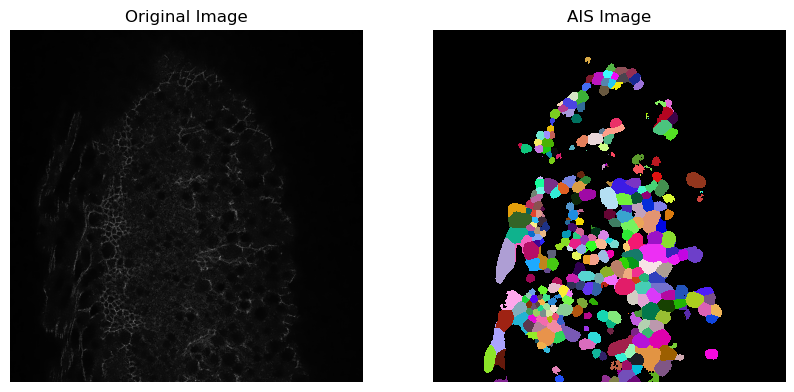

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch2[11], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel3Results[11], cmap=get_random_colors(channel3Results[11]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

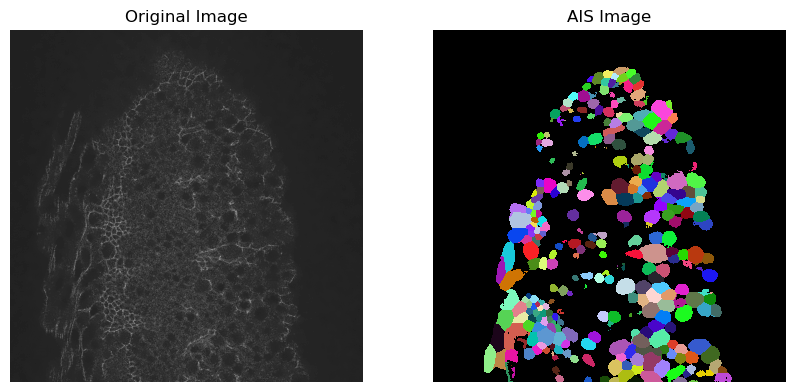

In [50]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch2[11], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel3Results[11], cmap=get_random_colors(channel3Results[11]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

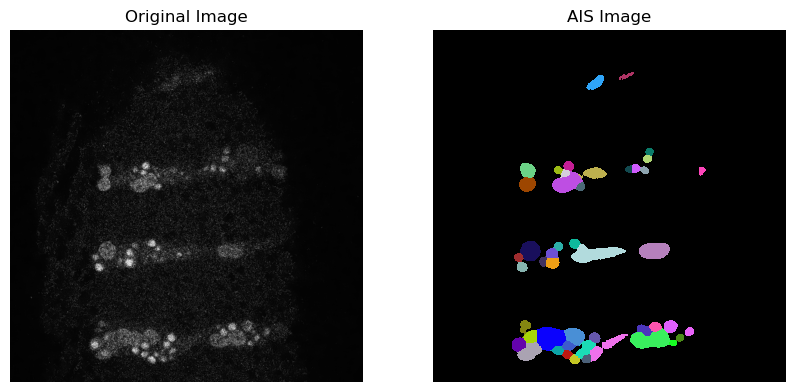

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch3[11], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel4Results[11], cmap=get_random_colors(channel4Results[11]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

Text(0.5, 1.0, 'AIS Image')

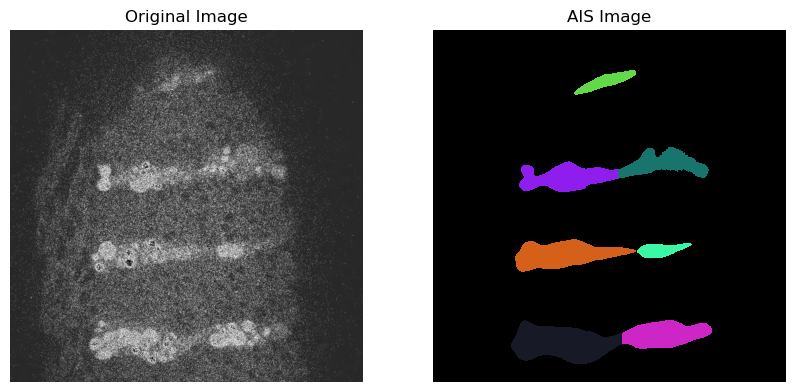

In [51]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

ax[0].imshow(ch3[11], cmap="gray")
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(channel4Results[11], cmap=get_random_colors(channel4Results[11]), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("AIS Image")

In [45]:
#Exporting the annotations to a Tiff File
#https://numpy.org/doc/stable/reference/generated/numpy.stack.html
#https://pypi.org/project/tifffile/
#Need to convert list to numpy array
# Need to pad the inner sequences to the same length to then be exported as a tiff file


   
oneChan = np.array(channelResults)
twoChan = np.array(channel2Results)
threeChan = np.array(channel3Results)
fourChan = np.array(channel4Results)
combinedOutput = np.stack((oneChan, twoChan, threeChan, fourChan),axis=0)
fileName = "outputResults.tif"

tiff.imwrite(fileName, combinedOutput, photometric='rgba')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (54,) + inhomogeneous part.

# Tasks to do <br>
### Adjust labels for the cell membrane to be borders
### Ensure the labels are matching colour wise (stiching)
### Export these back as tiff files to view